In [33]:
import glob
import numpy as np
from music21 import converter, instrument, note, chord, stream
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import h5py
import IPython
import matplotlib.pyplot as plt

In [22]:
# input:  list of file names

# output: a list of strings where chords are a grouping of numerical notes, 
#         separated by '.'; notes are the note names themselves
def file_to_note_str(files):
    notes = []
    for file in files:
        # load file into Music21 stream to get list of all the notes and chords
        midi = converter.parse(file)
        notes_to_parse = None
        parts = instrument.partitionByInstrument(midi)
        # melodies must be in the same position! (Here the bass lines are in index 2 of the midi)
        notes_to_parse = parts.parts[2].recurse()
        for elem in notes_to_parse:
            if isinstance(elem, note.Note):
                notes.append(str(elem.pitch))
            elif isinstance(elem, chord.Chord):
                # append chords by encoding the id of every note in the chord together in a string separated by a dot
                notes.append('.'.join(str(n) for n in elem.normalOrder))
    return notes

In [23]:
# prepare the input sequences and corresponding output for the rnn

def prep_sequences(notes, sequence_length = 30):
    # pitchnames holds all the different notes/chords in a set
    pitchnames = sorted(set(notes))
    n_vocab = len(pitchnames)
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    input= []
    output = []
    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])
    num_patterns = len(input)
    input = np.reshape(input, (num_patterns, sequence_length, 1))
    # normalize
    input = input / float(n_vocab)
    
    output = to_categorical(output)
    print('pitchnames:\n', pitchnames)
    print('number of notes/chords\n', n_vocab)
    return input, output, n_vocab


In [24]:
# prepare the model 
def create_model(input, n_vocab):
#     model = Sequential()
#     model.add(LSTM(256, input_shape=(input.shape[1], input.shape[2]), return_sequences=True))
#     model.add(Dropout(0.3))
#     model.add(LSTM(512, return_sequences=True))
#     model.add(Dropout(0.3))
#     model.add(LSTM(256))
#     model.add(Dense(256))
#     model.add(Dropout(0.3))
#     model.add(Dense(n_vocab))
#     model.add(Activation('softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    # new model 
    model = Sequential()
    model.add(LSTM(512, input_shape=(input.shape[1], input.shape[2]), recurrent_dropout=0.3, return_sequences=True))
    model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
    model.add(LSTM(512))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    #opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return model 

In [26]:
# train the model based on the data, and output checkpoints that you can monitor and input to make predictions 
def train(model, input, output, epochs=100, batch_size=64):
    #print(input)
    fp = "weight_checkpoints/music/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
    checkpoint = ModelCheckpoint(fp, monitor='loss', verbose=0,save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    print(checkpoint)
    history_callback = model.fit(input, output, batch_size, epochs, callbacks=callbacks_list)
    return history_callback
    

In [27]:
# time to try tuning some hps, like batch size, sequence length, 
files = glob.glob("bass_mids/*.MID")
def train_rnn(files):
    notes = file_to_note_str(files)
    input, output, n_vocab = prep_sequences(notes)
    model = create_model(input, n_vocab)
    print(input.shape)
    hist_callback = train(model, input, output)
    return hist_callback
    

In [28]:
hist_callback = train_rnn(files)

pitchnames:
 ['0.4', '0.5', '1.6', '10.11', '2.6', '3.6', '4.10', '4.6', '6.11', '7.0', 'A3', 'A4', 'B-2', 'B-3', 'B-4', 'B-5', 'B2', 'B3', 'C#4', 'C4', 'C5', 'C6', 'D3', 'D4', 'D5', 'D6', 'E-4', 'E-5', 'E5', 'F#2', 'F#4', 'F4', 'F5', 'G#4', 'G3', 'G4', 'G5']
number of notes/chords
 37
(4845, 30, 1)
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
76/76 [==============================] - 69s 887ms/st

76/76 [==============================] - 776s 10s/step - loss: 0.1096
Epoch 84/100
76/76 [==============================] - 73s 960ms/step - loss: 0.1259
Epoch 85/100
76/76 [==============================] - 96s 1s/step - loss: 0.1052
Epoch 86/100
76/76 [==============================] - 260s 3s/step - loss: 0.1199
Epoch 87/100
76/76 [==============================] - 138s 2s/step - loss: 0.1952
Epoch 88/100
76/76 [==============================] - 186s 2s/step - loss: 0.1563
Epoch 89/100
76/76 [==============================] - 172s 2s/step - loss: 0.1015
Epoch 90/100
76/76 [==============================] - 90s 1s/step - loss: 0.1358
Epoch 91/100
76/76 [==============================] - 635s 8s/step - loss: 0.1441
Epoch 92/100
76/76 [==============================] - 993s 13s/step - loss: 0.1658
Epoch 93/100
76/76 [==============================] - 859s 11s/step - loss: 0.0957
Epoch 94/100
76/76 [==============================] - 218s 3s/step - loss: 0.0950
Epoch 95/100
76/76 [======

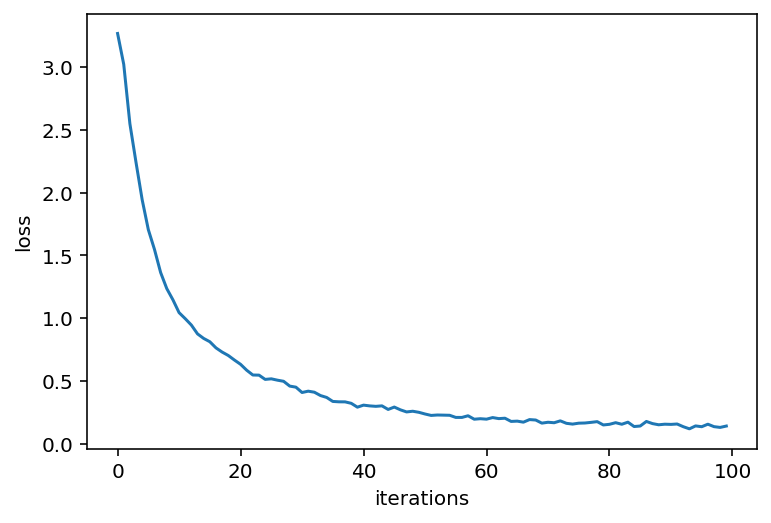

In [31]:
loss = plt.plot(hist_callback.history['loss'])
loss = plt.xlabel('iterations')
loss = plt.ylabel('loss')

In [11]:
notes = file_to_note_str(files)
input, output, n_vocab = prep_sequences(notes)
pitchnames = sorted(set(notes))

pitchnames:
 ['0.4', '0.5', '1.6', '10.11', '2.6', '3.6', '4.10', '4.6', '6.11', '7.0', 'A3', 'A4', 'B-2', 'B-3', 'B-4', 'B-5', 'B2', 'B3', 'C#4', 'C4', 'C5', 'C6', 'D3', 'D4', 'D5', 'D6', 'E-4', 'E-5', 'E5', 'F#2', 'F#4', 'F4', 'F5', 'G#4', 'G3', 'G4', 'G5']
number of notes/chords
 37


In [60]:
# model = Sequential()
# model.add(LSTM(256, input_shape=(input.shape[1], input.shape[2]), return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(512, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(256))
# model.add(Dense(256))
# model.add(Dropout(0.3))
# model.add(Dense(n_vocab))
# model.add(Activation('softmax'))
# model.load_weights("weight_checkpoints/music/weights-improvement-109-0.0711.hdf5")

In [19]:
# updated model 
model = Sequential()
model.add(LSTM(512, input_shape=(input.shape[1], input.shape[2]), recurrent_dropout=0.3, return_sequences=True))
model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
model.add(LSTM(512))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.load_weights("weights.hdf5")

In [20]:
start = np.random.randint(0, len(input) -1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = input[start]
pred_output = []
for note_index in range(500):
    # make it 1,50,1 instead of 50,1
    pred_input = np.reshape(pattern, (1,len(pattern), 1))
    # normalize input
    pred_input = pred_input / float(n_vocab)
    # predict w/ model
    pred = model.predict(pred_input, verbose=0)
    # get the most likely index of the next note => can change this to any somewhat likely index for more spontaneity
    index = np.argmax(pred)
    # convert to note form 
    result = int_to_note[index]
    # append the result to the output
    pred_output.append(result)
    pattern = np.append(pattern,index)
    pattern = pattern[1:len(pattern)]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [21]:
print(pred_output)

['A4', 'A4', 'A4', 'A4', 'A4', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'B-2', '4.10', 'B-2', '4.10', 'B-2', '2.6', 'D3', '2.6', 'D3', '6.11', 'B2', '6.11', 'B2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'B-2', '4.10', 'B-2', '4.10', 'B-2', '2.6', 'D3', '2.6', 'D3', '6.11', 'B2', '6.11', 'B2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'B-2', '4.10', 'B-2', '4.10', 'B-2', '2.6', 'D3', '2.6', 'D3', '6.11', 'B2', '6.11', 'B2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'F#2', '4.6', 'B-2', '4.10', 'B-2', '4.10', 'B-2', '2.6', 'D3', '2.6', 'D3', '6.11', 'B2', '6.11', 'B2', '4.6', 'F#2', '4.6', 'F#

In [22]:
# translate chords/notes
offset = 0
output_notes = []
for pattern in pred_output:
    # for chords
    if ('.' in pattern) or pattern.isdigit():
        chord_notes = pattern.split('.')
        notes = []
        for cur_note in chord_notes:
            n_note = note.Note(int(cur_note))
            n_note.storeInstrument = instrument.Bass()
            notes.append(n_note)
        n_chord = chord.Chord(notes)
        n_chord.offset = offset
        output_notes.append(n_chord)
    # for notes (mostly all w/ the bass)
    else:
        n_note = note.Note(pattern)
        n_note.offset = offset
        n_note.storedInstrument = instrument.Bass()
        output_notes.append(n_note)
    # increase offset 
    offset+=0.5
        

In [23]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='output/test_out4.mid')

'output/test_out4.mid'